# EPPE is short for 'EnergyPLAN Power Flow'
## It attempts to perform power flow optimization based on outputs from EnergyPLAN.
## It leans heavily on some packages, namely gurobi, networkx, pandas.

In [1]:
from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import gurobipy as gb
import timeit
import networkx as nx
from vresutils import timer
from multiprocessing import Pool
import matplotlib.pyplot as plt
%matplotlib inline

## The following function drops superfluous data points, to avoid warning from Gurobi

In [2]:
def drop_duplicates_from_index(self,keep='first',inplace=False):
    """Return self with duplicate indices removed
    Parameters
    ----------
    keep : {'first_last', first', 'last', False}, default 'first'
        - ``first_last`` : Drop duplicates except for the first and the last occurence
        - otherwise default 'drop_duplicates' behaviour.
    """
    if keep=='first_last':
        result = self[np.logical_not(self.index.duplicated(keep='first')) | np.logical_not(self.index.duplicated(keep='last'))]
    else:
        result = self[np.logical_not(self.index.duplicated(keep=keep))]
    if inplace:
        return self._update_inplace(result)
    else:
        return result
pd.Series.drop_duplicates_from_index = drop_duplicates_from_index

## Load data, calculate incidence matrix and PTDF matrix

In [3]:
# load graph data
nodes = pd.read_csv("data/graph/nodes.csv",header=None,squeeze=True).values
edges = pd.read_csv("data/graph/edges.csv",header=None).values
network = nx.Graph()
network.add_nodes_from(nodes)
network.add_edges_from(edges)
nodes = network.nodes()
edges = network.edges()
# assume link susceptances are equal
link_susceptances = np.ones(len(network.edges()))

# the dimension of incidence matrix is n*l
K = (-nx.incidence_matrix(network,oriented=True)).toarray()
O = np.diag(link_susceptances)
B_inverse = np.linalg.pinv((K.dot(O)).dot(K.T))
H = (O.dot(K.T)).dot(B_inverse)
H[abs(H)<1e-13]=0

# load Cost-Balancing data from EnergyPLAN
CB = {}
for n in nodes:
    df = pd.read_csv("data/cost_blancing/{}.csv".format(n),index_col=0,sep=',')
    df.columns = pd.to_numeric(df.columns.values)
    # convert from MWh to GWh
    CB[n] = df/1e3
pp = CB[nodes[0]].columns.values.tolist()
epsilon = 1e-2
INF = gb.GRB.INFINITY
Fl_b = INF

## Perform the flow optimization for each time step independently, and store the result in a pandas dataframe

In [4]:
def EPPF(timespan):
    T = timespan
    results = pd.DataFrame()

    for t in T:
        # initialize the gurobi model
        m = gb.Model()
        m.setParam('OutputFlag', 0)
        m.Params.Threads = 1
        
        # create the variable called total flow, positive indicates export and negative corresponds to import
        fl_t = [m.addVar(lb=-Fl_b,ub=Fl_b,name='link {}-{}'.format(bus0,bus1)) for bus0,bus1 in edges]
        Obj = gb.QuadExpr()
        Obj.addTerms(np.repeat(epsilon,len(edges)),fl_t,fl_t)

        # add fl_t^2 to the objective function, weighted by epsilon
        m.setObjective(expr=Obj)

        b = {}
        p = {}
        lbs =[]
        for n in nodes:
            b[n] = CB[n].loc[t,:].values.tolist()
            lbs.append(b[n][0])
            a = pd.Series(index=b[n],data=pp)
            a = a.drop_duplicates_from_index(keep='first_last')
            a.sort_index(inplace=True)
            b[n] = a.index.values
            p[n] = a.values

        # create the variable called Response
        R = [m.addVar(lb=lb, name='R {}'.format(node)) for node,lb in zip(nodes,lbs)]
        m.update()

        # add piecewise linear objective function, 
        [m.setPWLObj(R[nn],b[node],p[node]*(b[node]-b[node][0])) for nn,node in enumerate(nodes)]


        # add two more variables, namely injection and curtailment
        P = [m.addVar(lb=-INF, name='P {}'.format(node)) for node in nodes]
        C = [m.addVar(lb=0., name='C {}'.format(node)) for node in nodes]
        m.update()

        # R = P+C
        [m.addConstr(R[nn]-P[nn]-C[nn] == 0) for nn in range(len(nodes))]

        # F = H*P
        [m.addConstr(fl_t[ll]-gb.LinExpr(H[ll],P) == 0) for ll in range(len(edges))]
        m.addConstr(gb.quicksum(P) == 0)

        m.optimize()

        # store the result into a dataframe
        d = {}
        for v in m.getVars():
            d[v.VarName] = v.X
        df = pd.DataFrame([d],columns=d.keys().sort())
        results = pd.concat([results,df])
    results.index=T
    return results

In [5]:
%%time
def chunks(l, n):
    n = max(1, n)
    return (l[i:i+n] for i in xrange(0, len(l), n))
T_whole = np.arange(1,1+168)
cores = 4
n_T = int(len(T_whole)/cores)
L_T = list(chunks(T_whole,n_T))
p = Pool(cores)
r = p.map(EPPF,L_T)
results = pd.DataFrame()
for i in range(len(r)):
    results = pd.concat([results,r[i]])

In [7]:
results

C AT      C BA      C BE      C BG      C CH      C CZ      C DE  \
1    0.000000  0.000000  1.225068  0.000000  0.752111  0.687024  0.000000   
2    0.000000  0.000000  1.768027  0.000000  2.353535  2.469922  0.000000   
3    0.000000  0.000000  2.521000  0.000000  2.380670  2.152865  0.824836   
4    0.000000  0.000000  2.394909  0.000000  2.778950  2.499499  1.465473   
5    0.000000  0.000000  2.875636  0.000000  2.788144  1.943386  1.373291   
6    0.000000  0.000000  2.747909  0.000000  3.464986  1.749561  2.170234   
7    0.000000  0.000000  3.308000  0.000000  3.697798  2.126564  2.732426   
8    0.000000  0.000000  3.405000  0.000000  3.406106  2.106809  2.569723   
9    0.000000  0.244000  3.070000  0.794000  3.740641  1.886146  2.993559   
10   0.000000  0.777000  3.276000  1.427000  3.591686  2.063165  2.934266   
11   0.000000  0.653000  2.932000  1.814000  3.189191  1.653255  2.494702   
12   0.000000  0.348000  2.988000  2.134000  3.159614  1.107194  2.292378   
13   0.000000  0.000000  1.630576  1.142199  2.043196  0.000000  0.000000   
14   0.000000  0.000000  0.449728  0.946697  0.041811  0.000000  0.000000   
15   0.000000  0.163444  0.372623  1.449196  0.000000  0.000000  0.000000   
16   0.000000  0.120978  0.652989  1.411203  0.114188  0.000000  0.334729   
17   0.000000  0.641022  1.455106  1.465127  0.139403  0.686851  0.924316   
18   0.000000  1.096000  1.131404  2.420180  0.000000  1.145011  1.759203   
19   0.000000  0.800462  1.166129  2.099487  0.000000  1.693536  1.434701   
20   0.000000  0.809000  0.285927  2.173636  0.000000  1.451643  0.287128   
21   0.000000  0.409749  0.000000  1.210978  0.000000  0.837559  0.000000   
22   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
23   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
24   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
25   0.000000  0.000000  0.000000  1.739048  0.000000  0.000000  0.000000   
26   0.000000  0.000000  0.000000  2.314000  0.000000  1.860051  0.000000   
27   0.000000  0.000000  0.000000  2.785000  0.000000  2.399145  0.000000   
28   0.000000  0.000000  0.000000  2.647000  0.000000  3.193598  0.595425   
29   0.000000  0.000000  0.000000  3.017000  0.000000  3.381826  1.785767   
30   0.000000  0.000000  0.000000  2.839000  0.000000  3.482878  1.745337   
..        ...       ...       ...       ...       ...       ...       ...   
139  0.000000  0.000000  0.000000  0.218531  0.000000  0.000000  0.000000   
140  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
141  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
142  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
143  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
144  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
145  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
146  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
147  0.000000  0.000000  0.000000  0.038529  0.000000  0.000000  0.000000   
148  0.726342  0.000000  0.000000  0.987941  0.000000  0.000000  0.000000   
149  1.180328  0.000000  0.000000  0.609000  0.000000  0.000000  0.000000   
150  1.012670  0.000000  0.000000  0.981000  2.401266  0.000000  0.000000   
151  1.359116  0.000000  0.000000  1.137000  3.226133  0.000000  0.000000   
152  1.258282  0.127401  0.000000  0.889000  3.487417  0.000000  0.000000   
153  1.976918  0.884000  0.000000  1.121000  3.801801  0.000000  0.000000   
154  1.671672  0.686000  0.000000  0.909000  3.613292  0.000000  0.000000   
155  1.858073  0.909000  0.000000  0.363000  3.759829  0.000000  0.000000   
156  0.123962  0.270392  0.000000  0.061392  2.889840  0.000000  0.000000   
157  0.000000  0.000000  0.000000  0.000000  1.333183  0.000000  0.000000   
158  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
159  

In [8]:
results.to_csv('./results/EPPF.csv')

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Text yticklabel objects>)

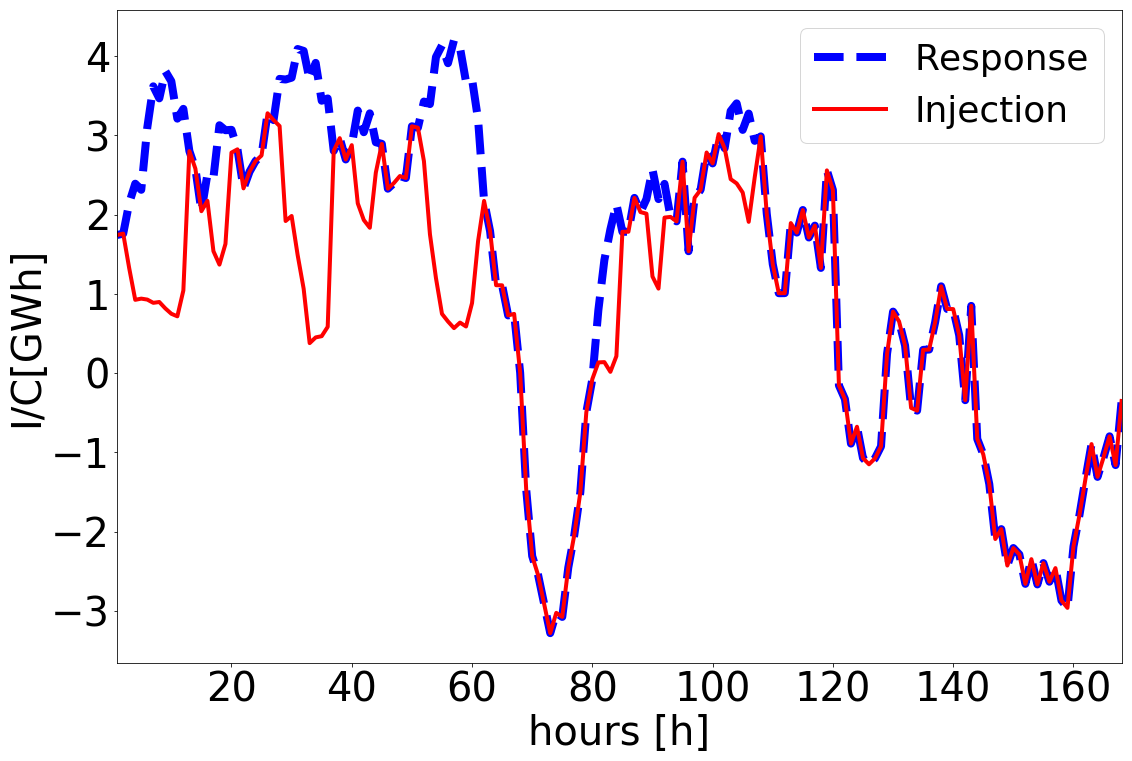

In [9]:
country = 'DE'
t_min = 0
t_max = 24*7

fonts = 40
tick = 40
linewidth = 4
fig,ax = plt.subplots()
fig.set_size_inches(18,12)
results.loc[t_min:t_max,'R '+country].plot(linewidth=linewidth*2,ax=ax,color='b',style='--')
results.loc[t_min:t_max,'P '+country].plot(linewidth=linewidth,ax=ax,color='r')
# results.loc[t_min:t_max,'C '+country].plot(linewidth=linewidth,ax=ax,color='k',style='--')
# plt.legend(['Injection','Curtailment'],fontsize=fonts*0.9)
plt.legend(['Response','Injection','Curtailment'],fontsize=fonts*0.9)
plt.xlabel('hours [h]',fontsize=fonts)
plt.ylabel('I/C[GWh]',fontsize=fonts)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)
# fig.savefig('./231117_CHP_workshop_slides/figures/RIC_{}_2.pdf'.format(country),dpi=500)

(array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]),
 <a list of 10 Text yticklabel objects>)

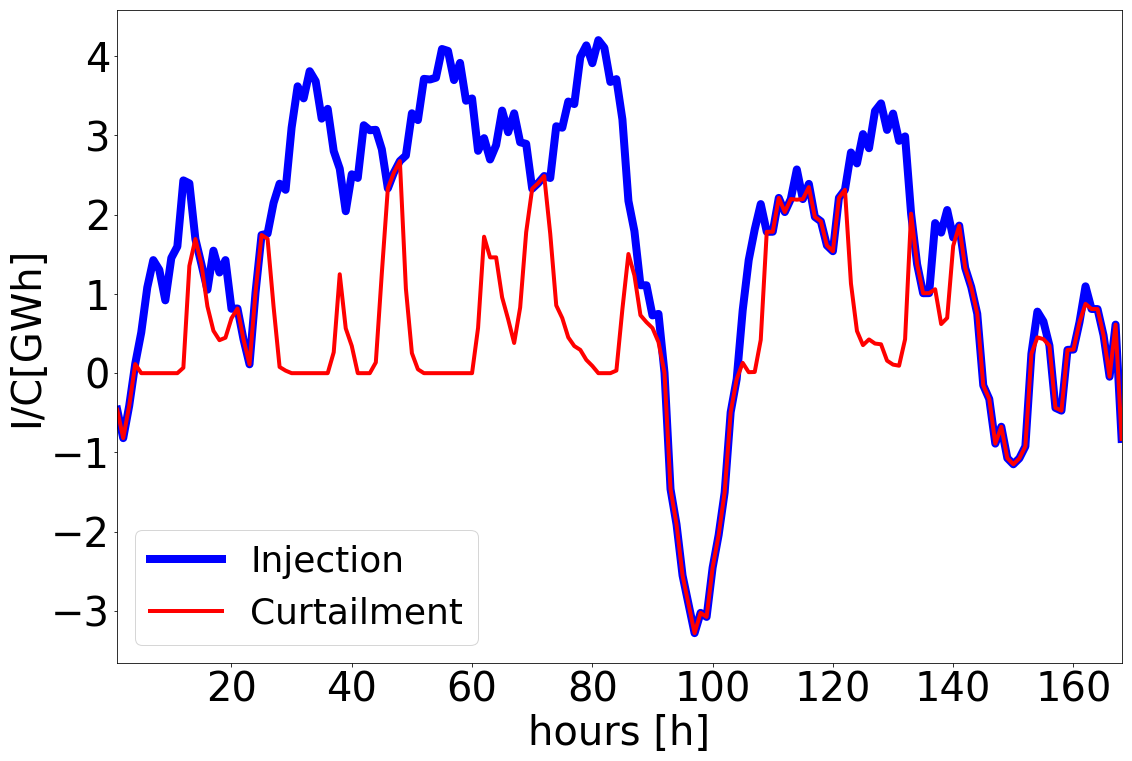

In [13]:
country = 'DK'
t_min = 0
t_max = 24*7

fonts = 40
tick = 40
linewidth = 4
fig,ax = plt.subplots()
fig.set_size_inches(18,12)
results.loc[t_min:t_max,'R '+country].plot(linewidth=linewidth*2,ax=ax,color='b')
results.loc[t_min:t_max,'P '+country].plot(linewidth=linewidth,ax=ax,color='r')
# results.loc[t_min:t_max,'C '+country].plot(linewidth=linewidth,ax=ax,color='k',style='--')
plt.legend(['Injection','Curtailment'],fontsize=fonts*0.9)
# plt.legend(['Response','Injection','Curtailment'],fontsize=fonts*0.9)
plt.xlabel('hours [h]',fontsize=fonts)
plt.ylabel('I/C[GWh]',fontsize=fonts)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)
# fig.savefig('./231117_CHP_workshop_slides/figures/RIC_{}.pdf'.format(country),dpi=500)

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5]),
 <a list of 10 Text yticklabel objects>)

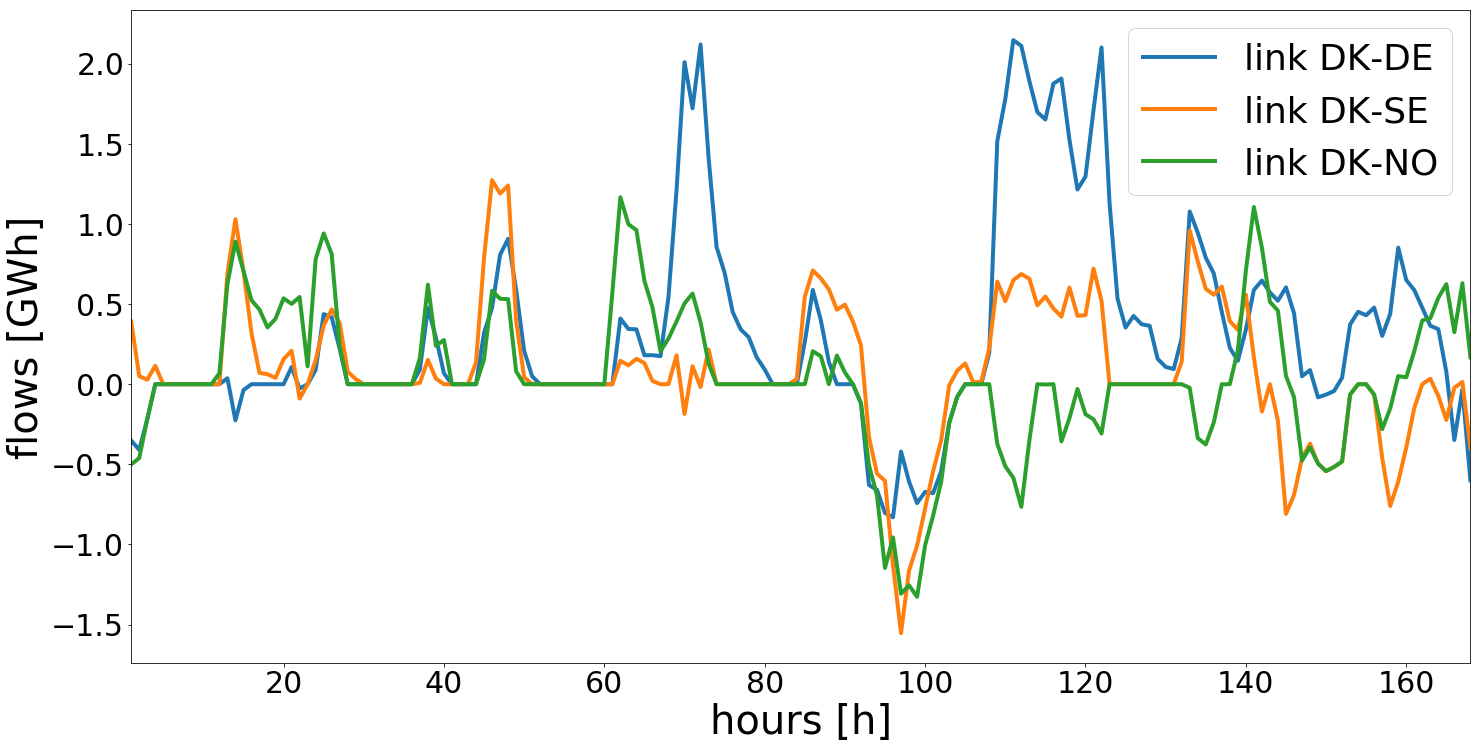

In [11]:
country = 'DK'
t_min = 0
t_max = 24*7
links = [edge for edge in edges if country in edge]

fonts=40
tick=30
linewidth=4
fig,ax = plt.subplots()
fig.set_size_inches(24,12)
legend = []
for link in links:
    if link[0]==country:
        (results.loc[t_min:t_max,'link '+link[0]+'-'+link[1]]).plot(linewidth=linewidth,ax=ax)
        legend.append('link '+link[0]+'-'+link[1])
    else:
        (-results.loc[t_min:t_max,'link '+link[0]+'-'+link[1]]).plot(linewidth=linewidth,ax=ax)
        legend.append('link '+link[1]+'-'+link[0])
plt.legend(legend,fontsize=fonts*0.9)
plt.xlabel('hours [h]',fontsize=fonts)
plt.ylabel('flows [GWh]',fontsize=fonts)
plt.xticks(fontsize=tick)
plt.yticks(fontsize=tick)
# fig.savefig('./231117_CHP_workshop_slides/figures/Links_{}.pdf'.format(country),dpi=500)

In [12]:
# p = np.zeros(30)
# p[0] = 2
# p[-1] = -2
# f = H.dot(p)
# f.max()